In [2]:
import pandas as pd
import numpy as np
import xlrd
from sklearn import preprocessing


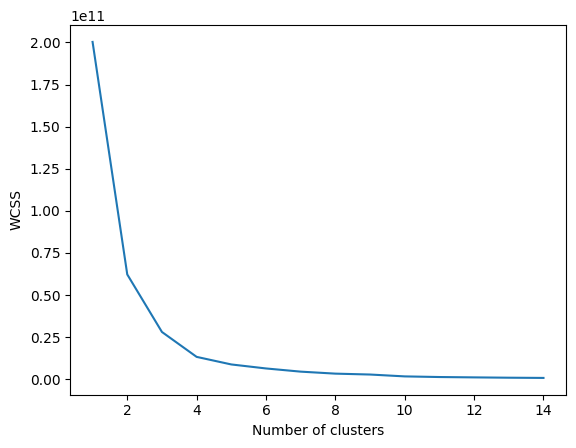

In [2]:
import matplotlib.pyplot as plt

dataset = pd.read_excel('NIMS_43A_steel_tubes_cleaned_data.xlsx')
X = dataset.iloc[1:, 1:19].values

from sklearn.cluster import KMeans
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss)    #within-cluster sum of squares
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [3]:
def load_data(input_file):
    source_data = pd.read_excel(input_file)
    np_data = source_data.iloc[:, 1:].values
    return source_data, np_data

def data_preprocess(np_data):
    array_data = np.zeros(np_data.shape)  #storing scaled data
    for i in range(np_data.shape[1]):
        array_data[:, i] = preprocessing.minmax_scale(np_data[:, i])
    print("input data dim -",np_data.shape)
    return array_data




In [3]:
def cluster_split(array_data):
    print(array_data[1, 1:-1])
    return array_data[:, 1:-1]


def train_cluster(train_data, array_data, source_data):
    from sklearn.cluster import KMeans
    model = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
    model.fit(train_data)
    label = np.zeros((len(model.labels_), 1), dtype=int)
    for i in range(len(model.labels_)):
        label[i, 0] = int(model.labels_[i])

    # print(labels)
    combine = np.concatenate((array_data, label), axis=1)
    writer = pd.ExcelWriter('6_cluster_points_without_scaling.xlsx')
    r0 = pd.concat([pd.DataFrame(array_data[:, 1:3]), pd.DataFrame(model.labels_)], axis=1)

    r0.columns = ['temp', 'stress', 'label']
    r0.to_excel(writer, sheet_name='cluster_label')
    for i in range(len(np.unique(model.labels_))):
        cluster_subset = combine[combine[:, -1] == i][:, :-1]
        r0 = pd.DataFrame(np.arange(0, int(len(cluster_subset[:, 0])), 1).T)
        r1 = pd.DataFrame(cluster_subset)
        r = pd.concat([r0, r1], axis=1)
        r.columns = list(source_data.columns)
        r.to_excel(writer, sheet_name='cluster_'+str(i))
    plot_cluster(train_data, model.labels_)

    writer.close()
    print("training data dim -",train_data.shape)
    
def plot_cluster(data_zs, r):
    from sklearn.manifold import TSNE

    tsne = TSNE()
    tsne.fit_transform(data_zs)  #Perform data dimensionality reduction to two dimensions
    # a=tsne.fit_transform(data_zs) #a is an array, which is equivalent to the following tsne_embedding_
    tsne = pd.DataFrame(tsne.embedding_)  # Convert data format

    import matplotlib.pyplot as plt

    d = tsne[r == 0]
    plt.plot(d[0], d[1], 'k.')

    d = tsne[r == 1]
    plt.plot(d[0], d[1], 'r.')

    d = tsne[r == 2]
    plt.plot(d[0], d[1], 'y.')

    d = tsne[r == 3]
    plt.plot(d[0], d[1], 'g.')

    d = tsne[r == 4]
    plt.plot(d[0], d[1], 'c.')
    
    d = tsne[r == 5]
    plt.plot(d[0], d[1], 'b.')


    plt.plot(d[0], d[1], '#EE82EE',marker='.',linestyle='dotted')

    plt.show()


def run_cluster():                  
    input_file = 'NIMS_43A_steel_tubes_cleaned_data.xlsx'
    re_source_data, np_data = load_data(input_file)
    array_data = data_preprocess(np_data)
    train_data = cluster_split(array_data)
    train_cluster(train_data, np_data, re_source_data) #change this to train_cluster(train_data, array_data, re_source_data) to see scaled data in the output excel file

#if __name__ == "__main__":
    #run_cluster()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,r2_score
import math


def pre_progressing(original_data):
    #Scaling X: Min-Max Scaling Y:unscaled
    data = original_data[:, :-1]
    target = original_data[:, -1]
    target = np.array(target, dtype=float)  # Ensure target is a float array
    print(target)
    scaled_data = MinMaxScaler().fit_transform(data)
    scaled_target = np.log(target)
    #scaled_target= scaled_target.reshape(-1, 1)  # Ensure target is a 2D array
    print("log scaled target", scaled_target)
    return scaled_data, scaled_target

def gaussian_model():
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel, RBF
    from sklearn.gaussian_process.kernels import ConstantKernel as C
    parameter = ' gaussian_model_with_RBF '
    rq_kernel = C(1, (0.001, 1000)) * RationalQuadratic(alpha=0.01, length_scale_bounds=(0.1, 1500))
    rbf_kernel = C(1, (0.001, 1000)) * RBF(length_scale=1.0, length_scale_bounds=(0.1, 1000))
    kernel = rq_kernel + rbf_kernel
    model = GaussianProcessRegressor(kernel=kernel, alpha=0.008, n_restarts_optimizer=20)
    return model, parameter

def svr_model():
    from sklearn.svm import SVR
    parameter = 'SVR with RBF kernel'
    model = SVR(kernel = 'rbf', C = 100, gamma = 0.1, epsilon = 0.1)
    return model, parameter

def random_forest_model():
    #random forest model
    from sklearn.ensemble import RandomForestRegressor
    parameter = ' RandomForest_model '
    model = RandomForestRegressor(n_estimators=50, max_depth=6, criterion='absolute_error', bootstrap=True,random_state=42)
    return model, parameter

def ridge_model():
    from sklearn.linear_model import Ridge
    parameter = ' Ridge_model '
    model = Ridge(alpha=0.01, random_state=42)
    return model, parameter



def network_model_2hiddenlayers():
    import random
    import tensorflow as tf
    from keras.models import Sequential
    from keras.layers import Dense , Input
    from keras.optimizers import Adam
    from keras.regularizers import l2
    
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    alpha = 0.01
    optimizer = Adam(learning_rate=0.01)

    model = Sequential([
        Input(shape=(16,)),
        Dense(units=100, activation='relu', kernel_regularizer=l2(alpha)),
        Dense(units=50, activation='relu', kernel_regularizer=l2(alpha)),
        Dense(units=1, activation='linear')
    ])
    model.compile(loss="MAE", optimizer=optimizer, metrics=['accuracy'])
    parameter = 'NeuralNetwork_model_2hiddenlayers'
    return model, parameter

def network_model_3hiddenlayers():  #I think I need to increase the number of hidden layers
    import random
    import numpy as np
    import tensorflow as tf
    from keras.models import Sequential
    from keras.layers import Dense , Input
    from keras.optimizers import Adam
    from keras.regularizers import l2
    
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    alpha = 0.01
    optimizer = Adam(learning_rate=0.01)

    model = Sequential([
        Input(shape=(16,)),
        Dense(units=100, activation='relu', kernel_regularizer=l2(alpha)),
        Dense(units=50, activation='relu', kernel_regularizer=l2(alpha)),
        Dense(units=50, activation='relu', kernel_regularizer=l2(alpha)),
        Dense(units=25, activation='relu', kernel_regularizer=l2(alpha)),
        Dense(units=25, activation='relu', kernel_regularizer=l2(alpha)),
        Dense(units=1, activation='linear')
    ])
    model.compile(loss="MAE", optimizer=optimizer, metrics=['accuracy'])
    parameter = 'NeuralNetwork_model_3hiddenlayers'
    return model, parameter

def fitness_fuction(y_pred, y_true):
    return 1-abs(np.sum((y_pred-y_true)/y_true)/len(y_pred))

def mape_function(y_pred, y_true):
    return abs(np.sum((y_pred - y_true) / y_true) / len(y_pred))





In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from  tensorflow import keras
from sklearn.metrics import mean_squared_error,r2_score



def get_feature_importance():
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    df = pd.read_excel("NIMS_43A_steel_tubes_cleaned_data.xlsx")
    feature_name = [column for column in df][1:]
    print(feature_name)
    sample_data = df.values[:, 1:] 
    print(sample_data)
    original_dataX = sample_data[:, :-1]
    train_dataX, train_dataY = pre_progressing(sample_data)
    k = 10 
    kf = KFold(n_splits=k)
    rf = RandomForestRegressor(random_state=42)
    rf.fit(train_dataX, train_dataY)
    feature_impor_all_data = rf.feature_importances_
    f_importances = np.zeros(train_dataX.shape[1],)
    for train_index, test_index in kf.split(train_dataX):
        trainX, trainY = train_dataX[train_index], train_dataY[train_index]
        testX, testY = train_dataX[test_index], train_dataY[test_index]
        rf.fit(trainX, trainY)
        f_importances+=rf.feature_importances_
    x_train, x_test, y_train, y_test = train_test_split( train_dataX, train_dataY, test_size=0.1, random_state=0)
    rf = RandomForestRegressor(random_state=42)
    #gbr = GradientBoostingRegressor()
    rf.fit(x_train, y_train)

    print(rf.feature_importances_)
    importances = rf.feature_importances_
    average_importance = f_importances/k
    indices = np.argsort(average_importance)[::-1]
    features = []
    feature_importances = []
    for f in range(train_dataX.shape[1]):
        features.append(feature_name[indices[f]])
        feature_importances.append(average_importance[indices[f]])
        print("%2d) %-*s %f" % (f + 1, 20, feature_name[indices[f]],average_importance[indices[f]]))

    f_im = np.column_stack((features, feature_importances))
    df = pd.DataFrame(f_im, columns=["feature name", "importance"])
    df.to_excel("Feature_importance_withrf.xlsx")



def run_comparitive_experiments():
    #Six models compared with DCSA: SVR, GPR, RF, MLR, Lasso and Ridge
    df = pd.read_excel("NIMS_43A_steel_tubes_cleaned_data.xlsx")
    feature_name = [column for column in df][1:]
    #print(feature_name)
    sample_data = df.values[:, 1:]
    #print(sample_data)
    original_dataX = sample_data[:, :-1]
    train_dataX, train_dataY = pre_progressing(sample_data)
    train_dataY = train_dataY.astype(float).flatten()  # Ensure train_dataY is a 1D array
    k = 10  
    kf = KFold(n_splits=k)
    model1, parameter1 = gaussian_model()
    model2, parameter2 = svr_model()    
    model3, parameter3 = random_forest_model()
    model4, parameter4 = ridge_model()
    model5, parameter5 = network_model_2hiddenlayers()
    model6, parameter6 = network_model_3hiddenlayers()
    predicted_models = [model1, model2, model3, model4, model5, model6]
    model_name = ["GPR","SVR", "RF", "Ridge","Neural_Network2","Neural_Network3"]
    #model_accuracy = []
    model_rmse = []
    model_rmse_dev = []
    model_mape = []
    model_mape_dev = []
    model_r2 = []
    model_r2_dev = []
    model_index = 0
    for model_i in predicted_models:
        #sum_accuracy = 0
        sum_rmse = 0
        sum_mape = 0
        sum_r2 = 0
        y_pred = []
        mape_all = []
        rmse_all = []
        r2_all = []
        #accuracy_all = []

        for train_index, test_index in kf.split(train_dataX):
            trainX, trainY = train_dataX[train_index], train_dataY[train_index]
            testX, testY = train_dataX[test_index], train_dataY[test_index]

            if model_name in ["SVR","RF", "Ridge", "Neural_Network2","Neural_Network3"]:
                scaler_std = StandardScaler()
                trainX = scaler_std.fit_transform(trainX)
                testX = scaler_std.transform(testX)
            model = model_i
            if isinstance(model, keras.models.Sequential):
                model.fit(trainX, trainY, batch_size=32, epochs=100, verbose = 0) # verbose=0 to suppress output during training
            else:
                model.fit(trainX, trainY)
            
            # print(testY, model.predict(testX))
            predictedY = model.predict(testX)
            # predict_Y.append(model.predict(testX))
            model_i_mape = mape_function(predictedY, testY)
            sum_mape += model_i_mape
            model_i_r2 = r2_score(predictedY, testY)
            r2_all.append(model_i_r2)
            sum_r2 += model_i_r2
            y_pred.extend(predictedY)
            model_i_rmse = mean_squared_error(testY, predictedY)
            rmse_all.append(model_i_rmse)
            # fitness_all.append(fitness_fuction(predictedY, testY))
            mape_all.append(model_i_mape)
            # cross_score +=   r2_score(testY, predictedY)
            sum_rmse += model_i_rmse
            #model_i_accuracy = accuracy_score(testY, predictedY)
            #accuracy_all.append(model_i_accuracy)
            #sum_accuracy += model_i_accuracy

        rmse_dev = np.std(rmse_all)
        mape_dev = np.std(mape_all)
        r2_dev = np.std(r2_all)
        model_mape_dev.append(mape_dev)
        model_rmse_dev.append(rmse_dev)
        model_r2_dev.append(r2_dev)
        print(y_pred)
        print("The prediction accuracy mape is", sum_mape/k)
        print("The prediction accuracy rmse is", sum_rmse/k)
        #print("The prediction accuracy accuracy is", sum_accuracy/k)
        model_mape.append(sum_mape/k)
        model_rmse.append(sum_rmse/k)
        model_r2.append(sum_r2/k)
        #model_accuracy.append(sum_accuracy/k)
        #print("train_dataY type:", type(train_dataY))
        #print("y_pred type:", type(y_pred))
        y_pred_array = np.array(y_pred).astype(float)

        true_pred = np.column_stack((train_dataY, y_pred))
        predict_data = np.column_stack((original_dataX, true_pred))
        predict_data1 = np.column_stack((predict_data, np.exp(train_dataY)))
        predict_data2 = np.column_stack((predict_data1, np.exp(y_pred_array)))
        df1 = pd.DataFrame(predict_data2, columns=feature_name[:-1] + ["True_creeplife", "Predicted_creeplife",
                                                                       "Unscaled_True_creeplife", "Unscaled_Predicted_creeplife"])
        df1.to_excel("Comparative_results13_8_2025/" + model_name[model_index] + "_results.xlsx")
        model_index = model_index + 1
    model_results = np.column_stack((model_name, model_rmse))
    model_re1 = np.column_stack((model_results, model_rmse_dev))
    model_re2 = np.column_stack((model_re1, model_mape))
    model_re3 = np.column_stack((model_re2, model_mape_dev))
    model_re4 = np.column_stack((model_re3, model_r2))
    model_re5 = np.column_stack((model_re4, model_r2_dev))
    #model_re6 = np.column_stack((model_re5, model_accuracy))
    df2 = pd.DataFrame(model_re5, columns=["Prediction_model","rmse", "rmse_dev", "mape",
                                           "mape_dev", "r^2", "r^2_dev"])
    df2.to_excel("Comparative_results13_8_2025/Comparative_models_results1.xlsx")


#if __name__ == "__main__":
    #get_feature_importance()
    #run_comparitive_experiments()




In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score




In [ ]:
''' Results from predicted results excel file obtained after running the above code
Clusters    Selected optimal model    Fitness
1              GPR                    0.9684
2              SVR                    0.9817
3              GPR                    0.9706
4              GPR                    0.9702
5              GPR                    0.9747
6              GPR                    0.9741


'''
import pandas as pd
import os
import joblib
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler # Make sure StandardScaler is imported

MODEL_DIR = "model_for_each_cluster_withStdScaler"
os.makedirs(MODEL_DIR, exist_ok=True)


# Cluster configuration
cluster_model = {
    "cluster_0": "GPR",
    "cluster_1": "SVR",
    "cluster_2": "GPR",   
    "cluster_3": "GPR",   
    "cluster_4": "GPR",
    "cluster_5": "GPR",    
}
print("All models start running!")

# Load scaling data once
df_original = pd.read_excel("NIMS_43A_steel_tubes_cleaned_data.xlsx")
original_data = df_original.values[:, 1:-1]
scaler = MinMaxScaler()
scaler.fit(original_data)

for cluster, model_type in cluster_model.items():
    try:
        print(f"Processing {cluster} with {model_type}")
        
        # Load cluster data
        df = pd.read_excel("6_cluster_points_without_scaling_without_labelsheet0.xlsx", sheet_name=cluster)
        cluster_sample = df.values[:, 1:]
        data, target = cluster_sample[:, 1:-1], cluster_sample[:, -1]
        
        # Normalize data with MinMaxScaler
        data = scaler.transform(data)
        target = np.log(target)
        
        # Select model
        if model_type == "RF":
            model, _ = random_forest_model()
        elif model_type == "GPR":
            model, _ = gaussian_model()
        elif model_type == "SVR":
            model, _ = svr_model()
        elif model_type == "NN2":
            model, _ = network_model_2hiddenlayers()
        elif model_type == "NN3":
            model, _ = network_model_3hiddenlayers()
        elif  model_type == "ridge_model":
            model, _ = ridge_model()
        
        if model_type in ["SVR", "RF", "Ridge", "NN2", "NN3"]:
            std_scaler = StandardScaler()
            data = std_scaler.fit_transform(data)
            
            # Save the fitted StandardScaler
            scaler_path = os.path.join(MODEL_DIR, f"{cluster}{model_type}_scaler.pkl")
            joblib.dump(std_scaler, scaler_path)
            
        model.fit(data, target)
        model_path = os.path.join(MODEL_DIR, f"{cluster}{model_type}.model")
        joblib.dump(model, model_path)
        print(f"Saved model to {model_path}")
        
    except Exception as e:
        print(f"Error processing {cluster}: {str(e)}")
        continue

print("All models have been saved!")